In [6]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import requests
import math

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#Adapted from John's `estimate-clade-frequencies.ipynb`

In [7]:
tree_url = "https://data.nextstrain.org/ncov_global.json"
frequencies_url = "https://data.nextstrain.org/ncov_global_tip-frequencies.json"

In [8]:
#Download tip frequencies and tree jsons
frequencies = requests.get(frequencies_url).json()
tree_json = requests.get(tree_url).json()
#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

In [9]:
pivots = np.array(frequencies.pop("pivots"))
frequency_arrays = {
    strain: np.array(strain_frequencies["frequencies"])
    for strain, strain_frequencies in frequencies.items()
    if "frequencies" in strain_frequencies
}

In [10]:
#Sum frequencies of clades at all time points by summing children in postorder tree traversal
#i.e. work from tip back to internal node, summing frequencies

for node in tree.find_clades(order="postorder"):
    if node.is_terminal():
        # We already know the frequencies of each terminal node, so
        # store those frequencies with the corresponding node of the tree.
        node.frequencies = frequency_arrays[node.name]
    else:
        # For each internal node, sum the frequencies of its immediate
        # children. Since we are walking through the tree from the bottom
        # up, each child node will always have frequencies calculated
        # before its parent node.
        node.frequencies = np.array([
            child.frequencies
            for child in node.clades
        ]).sum(axis=0)

In [12]:
#Find the path from root to internal node and accumulate all mutations that have occurred along this path
#Keep track of these just for S1, S2, and RdRp 

def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path

for node in tree.find_clades():
    #Find all parents of the node
    parents = get_parent(tree, node)
    #Find mutations that occur in the parents
    parents_spike_muts = []
    parents_s1_muts = []
    parents_s2_muts = []
    parents_rdrp_muts = []
    for parent in parents:
        if hasattr(parent, "branch_attrs") and "mutations" in parent.branch_attrs:
            if "S" in parent.branch_attrs["mutations"]:
                parents_spike_muts+=parent.branch_attrs["mutations"]["S"]
                for mut in parent.branch_attrs["mutations"]["S"]: 
                    if int(mut[1:-1]) in range(13,686):
                        parents_s1_muts+=[mut]
                    elif int(mut[1:-1]) in range(687,1274):
                        parents_s2_muts+=[mut]
            #find RdRp muts
            elif "ORF1a" in parent.branch_attrs["mutations"]:
                for mut in parent.branch_attrs["mutations"]["ORF1a"]:
                    if int(mut[1:-1]) in range(4492,4401):
                        #renumber mut according to rdrp protein
                        rdrp_mut = f'{mut[0]}{int(mut[1:-1])-4492}{mut[-1]}'
                        parents_rdrp_muts+=[rdrp_mut]
            elif "ORF1b" in parent.branch_attrs["mutations"]:
                for mut in parent.branch_attrs["mutations"]["ORF1b"]:
                    if int(mut[1:-1]) in range(1,923):
                        #renumber mut according to rdrp protein
                        rdrp_mut = f'{mut[0]}{int(mut[1:-1])+9}{mut[-1]}'
                        parents_rdrp_muts+=[rdrp_mut]
                    
        

        
    node.spike_muts_accumulated = parents_spike_muts
    node.s1_muts_accumulated = parents_s1_muts
    node.s2_muts_accumulated = parents_s2_muts
    node.rdrp_muts_accumulated = parents_rdrp_muts

In [3]:
#plot num mutations until clade against clade growth rate, exponential growth

def plot_muts_v_rate(growth_period, period_length, filename=False):
    mut_accumulation_and_rate_by_clade = []

    for node in tree.find_clades(terminal=False):
        vocs = ["20H/501Y.V2", "20I/501Y.V1", "20J/501Y.V3"]
        voc_clade = False
        if 'clade_membership' in node.node_attrs:
            if node.node_attrs["clade_membership"]["value"] in vocs:
                voc_clade = node.node_attrs["clade_membership"]["value"]

        node_freqs = node.frequencies

        
        #calculate the intial clade growth
        #find first non-zero pivot
        growth_start = np.where(node_freqs!=0)[0][0]
        start_freq = node_freqs[growth_start]
        #calculate initial growth of clade (within first month)
        growth_end = growth_start+period_length
        if growth_end>=len(node_freqs):
            growth_end = len(node_freqs)

        end_freq = node_freqs[growth_end]

        #add pseudocount to avoid divide-by-zero errors
        initial_clade_exp = (end_freq + 0.00001)/(start_freq + 0.00001)
        initial_time_days = 365*(pivots[growth_end]-pivots[growth_start])
        intitial_clade_growth = initial_clade_exp/(initial_time_days)

        #calculate the clade growth in the most recent month
        recent_growth_start = -1 - period_length
        recent_clade_exp = (node_freqs[-1] + 0.00001) / (node_freqs[recent_growth_start] + 0.00001)
        recent_time_days = 365*(pivots[-1] - pivots[recent_growth_start])
        recent_clade_growth = recent_clade_exp/(recent_time_days)


        #make tidy dataframe
        mut_accumulation_and_rate_by_clade.append({'clade': node.name, 
                                                   'initial_growth_rate': intitial_clade_growth, 
                                                   'initial_dfreq': initial_clade_dfreq,
                                                   'recent_growth_rate': recent_clade_growth, 
                                                   'recent_dfreq': recent_clade_dfreq, 
                                                   's1_to_rdrp_mut_excess': (len(node.s1_muts_accumulated)-len(node.rdrp_muts_accumulated)),
                                                   'gene': 'S1',
                                                   'voc_clade': voc_clade,
                                                   'num_muts_accumulated': len(node.s1_muts_accumulated)})
        mut_accumulation_and_rate_by_clade.append({'clade': node.name, 
                                                   'initial_growth_rate': intitial_clade_growth, 
                                                   'initial_dfreq': initial_clade_dfreq,
                                                   'recent_growth_rate': recent_clade_growth, 
                                                   'recent_dfreq': recent_clade_dfreq, 
                                                   's1_to_rdrp_mut_excess': (len(node.s1_muts_accumulated)-len(node.rdrp_muts_accumulated)),
                                                   'gene': 'rdrp',
                                                   'voc_clade': voc_clade,
                                                   'num_muts_accumulated': len(node.rdrp_muts_accumulated)})





    mut_accumulation_and_rate_df = pd.DataFrame(mut_accumulation_and_rate_by_clade)

    cmap = {"20H/501Y.V2": "#9F2A44", "20I/501Y.V1": "#ED9AB0", "20J/501Y.V3": "#E06E85", False: "#76C7BE"}


    g = sns.FacetGrid(mut_accumulation_and_rate_df, col="gene", hue = "voc_clade", palette = cmap, 
                      size=6, aspect=1, legend_out=True)
    if growth_period == "initial":
        g.map(sns.scatterplot, "initial_growth_rate", "num_muts_accumulated")
        g.set_axis_labels("Initial Growth Rate", "Number of mutations accumulated (root to node)")
    elif growth_period == "recent":
        g.map(sns.scatterplot, "recent_growth_rate", "num_muts_accumulated")
        g.set_axis_labels("Recent Growth Rate", "Number of mutations accumulated (root to node)")       
    g.add_legend()
    g.set_titles(col_template="{col_name}")

    if filename:
        g.savefig(filename, dpi=300)
            

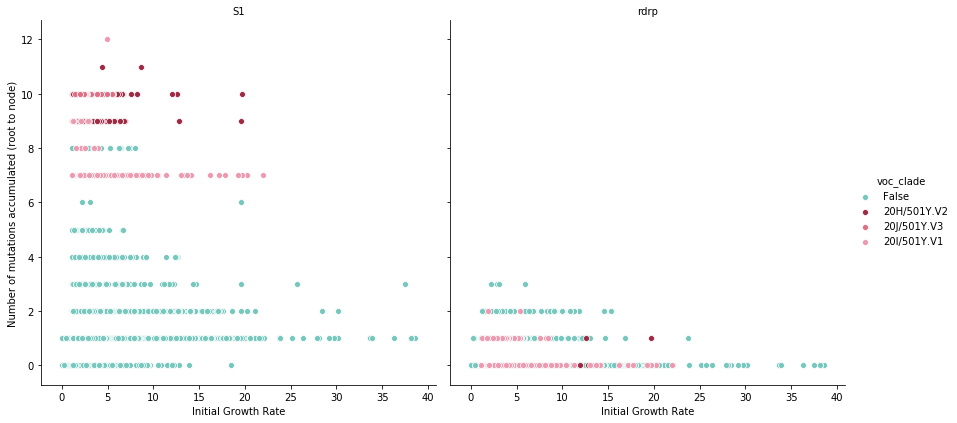

In [87]:
 plot_muts_v_rate('initial', 10)

In [25]:
#plot num mutations until clade against clade growth rate, logistic growth



def plot_muts_v_logisticgrowth(growth_period, period_length, filename=False):
    mut_accumulation_and_rate_by_clade = []

    for node in tree.find_clades(terminal=False):
        vocs = ["20H/501Y.V2", "20I/501Y.V1", "20J/501Y.V3"]
        voc_clade = False
        if 'clade_membership' in node.node_attrs:
            if node.node_attrs["clade_membership"]["value"] in vocs:
                voc_clade = node.node_attrs["clade_membership"]["value"]
                
        node_freqs = node.frequencies

        
        #calculate the intial clade growth
        #find first non-zero pivot
        if growth_period == 'initial':
            growth_start = np.where(node_freqs!=0)[0][0]
        elif growth_period == 'recent':
            growth_start = -1 - period_length
        x_0 = node_freqs[growth_start]
        #find end point, specified by period_length (given in pivots)
        growth_end = growth_start+period_length
        if growth_end>=len(node_freqs):
            growth_end = len(node_freqs)
            
        
        #find clade frequency at end point    
        x_t = node_freqs[growth_end]
        #frequency should never be greater than 1, though some may be slightly over 1 
        if x_t > 1.0:
            x_t = 1.0
        
        #Also add false count to zeros to prevent infinity
        if x_t == 0.0:
            x_t = 0.000001
        if x_0 == 0.0:
            x_0 = 0.000001
        
        #find length of period in days
        t = 365*(pivots[growth_end]-pivots[growth_start])
        
        #find logistic growth rate
        r = - np.log(((1.0-x_t) / x_t) / ((1.0/x_0)-1.0)) / t


        #make tidy dataframe
        mut_accumulation_and_rate_by_clade.append({'clade': node.name, 
                                                   'logistic_growth_rate': r, 
                                                   's1_to_rdrp_mut_excess': (len(node.s1_muts_accumulated)-len(node.rdrp_muts_accumulated)),
                                                   'gene': 'S1',
                                                   'voc_clade': voc_clade,
                                                   'num_muts_accumulated': len(node.s1_muts_accumulated)})
        mut_accumulation_and_rate_by_clade.append({'clade': node.name, 
                                                   'logistic_growth_rate': r, 
                                                   's1_to_rdrp_mut_excess': (len(node.s1_muts_accumulated)-len(node.rdrp_muts_accumulated)),
                                                   'gene': 'rdrp',
                                                   'voc_clade': voc_clade,
                                                   'num_muts_accumulated': len(node.rdrp_muts_accumulated)})





    mut_accumulation_and_rate_df = pd.DataFrame(mut_accumulation_and_rate_by_clade)

    cmap = {"20H/501Y.V2": "#9F2A44", "20I/501Y.V1": "#ED9AB0", "20J/501Y.V3": "#E06E85", False: "#76C7BE"}


    g = sns.FacetGrid(mut_accumulation_and_rate_df, col="gene", hue = "voc_clade", palette = cmap, 
                      size=6, aspect=1, legend_out=True)

    g.map(sns.scatterplot, "logistic_growth_rate", "num_muts_accumulated")
    g.set_axis_labels("Logistic Growth Rate", "Number of mutations accumulated (root to node)")
     
    g.add_legend()
    g.set_titles(col_template="{col_name}")

    if filename:
        g.savefig(filename, dpi=300)
            

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in log


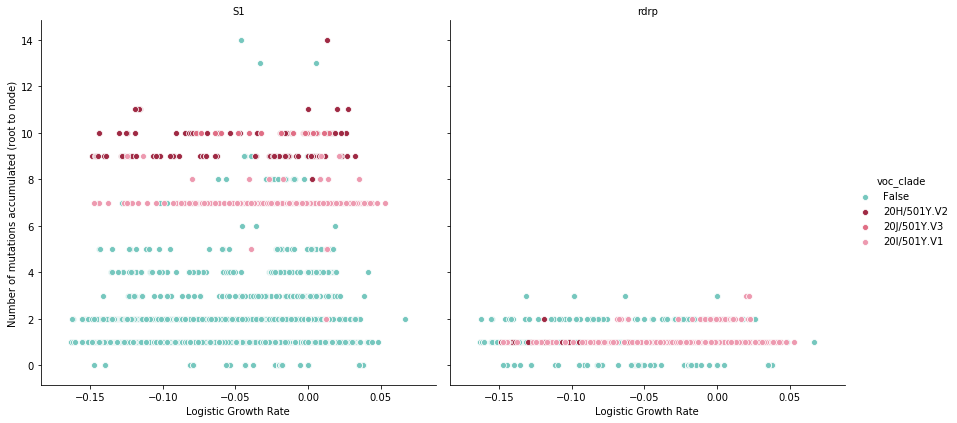

In [27]:
plot_muts_v_logisticgrowth('recent', 4)

In [28]:
#plot num mutations until clade against clade growth rate, logistic growth 
#(initial growth for clades that reach 1% freq)



def muts_v_logisticgrowth_initial(period_length, filename=False):
    mut_accumulation_and_rate_by_clade = []

    for node in tree.find_clades(terminal=False):
        vocs = ["20H/501Y.V2", "20I/501Y.V1", "20J/501Y.V3"]
        voc_clade = False
        if 'clade_membership' in node.node_attrs:
            if node.node_attrs["clade_membership"]["value"] in vocs:
                voc_clade = node.node_attrs["clade_membership"]["value"]
                
        node_freqs = node.frequencies
        
        #only use clades that reach at least 1% frequency
        if len(np.where(node_freqs>=0.01)[0])>=1:
            #calculate the intial clade growth
            #find first pivot where freq is greater than 1%

            growth_start = np.where(node_freqs>=0.01)[0][0]
            x_0 = node_freqs[growth_start]
            #find end point, specified by period_length (given in pivots)
            growth_end = growth_start+period_length
            if growth_end>=len(node_freqs):
                growth_end = len(node_freqs) -1

            #find clade frequency at end point    
            x_t = node_freqs[growth_end]
            #frequency should never be greater than 1, though some may be slightly over 1 
            if x_t > 1.0:
                x_t = 1.0
                
            #Also add false count to zeros to prevent infinity
            if x_t == 0.0:
                x_t = 0.000001
            if x_0 == 0.0:
                x_0 = 0.000001

            #find length of period in days
            t = 365*(pivots[growth_end]-pivots[growth_start])

            #find logistic growth rate
            r = - np.log(((1.0-x_t) / x_t) / ((1.0/x_0)-1.0)) / t


            #make tidy dataframe
            mut_accumulation_and_rate_by_clade.append({'clade': node.name, 
                                                       'logistic_growth_rate': r, 
                                                       's1_to_rdrp_mut_excess': (len(node.s1_muts_accumulated)-len(node.rdrp_muts_accumulated)),
                                                       'gene': 'S1',
                                                       'voc_clade': voc_clade,
                                                       'num_muts_accumulated': len(node.s1_muts_accumulated)})
            mut_accumulation_and_rate_by_clade.append({'clade': node.name, 
                                                       'logistic_growth_rate': r, 
                                                       's1_to_rdrp_mut_excess': (len(node.s1_muts_accumulated)-len(node.rdrp_muts_accumulated)),
                                                       'gene': 'rdrp',
                                                       'voc_clade': voc_clade,
                                                       'num_muts_accumulated': len(node.rdrp_muts_accumulated)})





    mut_accumulation_and_rate_df = pd.DataFrame(mut_accumulation_and_rate_by_clade)

    cmap = {"20H/501Y.V2":"#9F2A44", "20I/501Y.V1":"#208288", "20J/501Y.V3":"#0B194C", False: "#d3d3d3"}


    g = sns.FacetGrid(mut_accumulation_and_rate_df, col="gene", hue = "voc_clade", palette = cmap, 
                      size=6, aspect=1, legend_out=True)

    g.map(sns.scatterplot, "logistic_growth_rate", "num_muts_accumulated")
    g.set_axis_labels("Logistic Growth Rate", "Number of mutations accumulated (root to node)")
     
    g.add_legend()
    g.set_titles(col_template="{col_name}")

    if filename:
        g.savefig(filename, dpi=300)
            

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in double_scalars


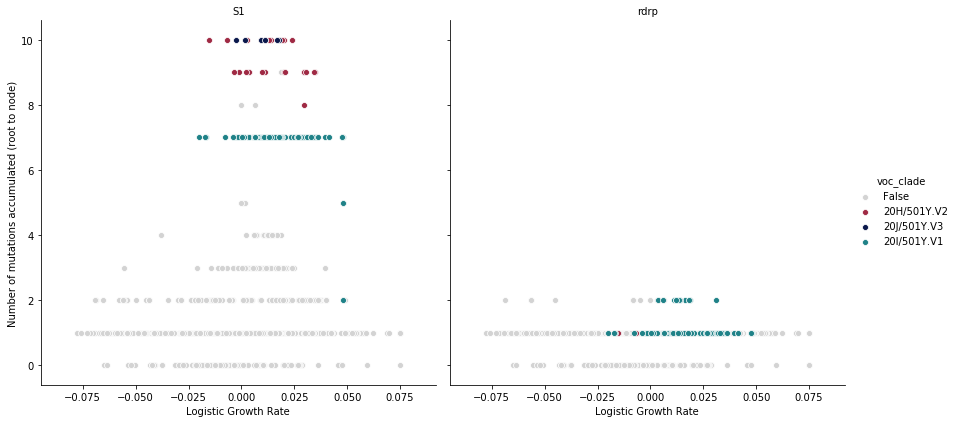

In [29]:
muts_v_logisticgrowth_initial(6, filename='clades_above_01_muts_v_rate.png')

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in double_scalars


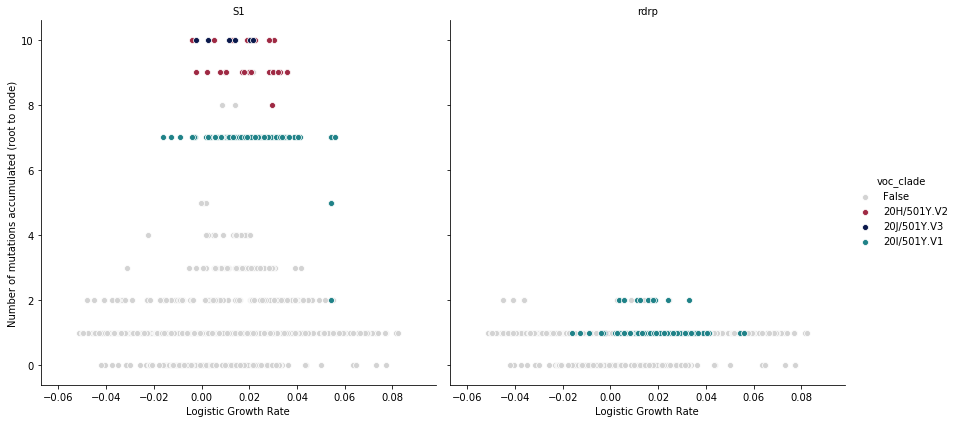

In [30]:
muts_v_logisticgrowth_initial(4)

In [46]:
def plot_frequency_and_logistic_growth_for_clade(period_length):

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    vocs = {"20H/501Y.V2":[], "20I/501Y.V1":[], "20J/501Y.V3":[]}

    for node in tree.find_clades(terminal=False):
        voc_clade = False
        if 'clade_membership' in node.node_attrs:
            if node.node_attrs["clade_membership"]["value"] in vocs.keys():
                if len(vocs[node.node_attrs["clade_membership"]["value"]])<1:
                    vocs[node.node_attrs["clade_membership"]["value"]].append(node.name)
                    voc_clade = node.node_attrs["clade_membership"]["value"]
                    node_name = node.name
                    node_freqs = node.frequencies
                    
                    cmap = {"20H/501Y.V2":"#9F2A44", "20I/501Y.V1":"#208288", "20J/501Y.V3":"#0B194C"}
    
                    ax.plot(
                        pivots,
                        node.frequencies,
                        color = cmap[voc_clade],
                        label = node.name,
                        lw=2
                    )

                    #calculate the intial clade growth
                    #find first non-zero pivot
                    growth_start = np.where(node_freqs>=0.01)[0][0]
                    x_0 = node_freqs[growth_start]
                    #find end point, specified by period_length (given in pivots)
                    growth_end = growth_start+period_length
                    if growth_end>=len(node_freqs):
                        growth_end = len(node_freqs) -1

                    #find clade frequency at end point    
                    x_t = node_freqs[growth_end]
                    #frequency should never be greater than 1, though some may be slightly over 1 
                    if x_t > 1.0:
                        x_t = 1.0
                    #Also add false count to zeros to prevent infinity
                    if x_t == 0.0:
                        x_t = 0.000001
                    if x_0 == 0.0:
                        x_0 = 0.000001

                    #find length of period in days
                    t = 365*(pivots[growth_end]-pivots[growth_start])

                    #find logistic growth rate
                    r = - np.log(((1.0-x_t) / x_t) / ((1.0/x_0)-1.0)) / t

                    t_array = np.linspace(pivots[growth_start], pivots[growth_end], 10)
                    delta_t_array = t_array-pivots[growth_start]
                    delta_t_array_days = delta_t_array*365



                    x_t_est= 1.0 / (1.0 + ((1.0/x_0) - 1.0)*(np.exp(-r*delta_t_array_days)))

                    cmap_log = {"20H/501Y.V2":"#E06E85", "20I/501Y.V1":"#76C7BE", "20J/501Y.V3":"#9DA3B7"}
                    ax.plot(t_array, x_t_est, label=f'logistic growth {node_name}', 
                            color = cmap_log[voc_clade], ls='--', lw=5)



    ax.set_xlabel("Date")
    ax.set_ylabel("Frequency")

    ax.legend(
        frameon=False,
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.
    )

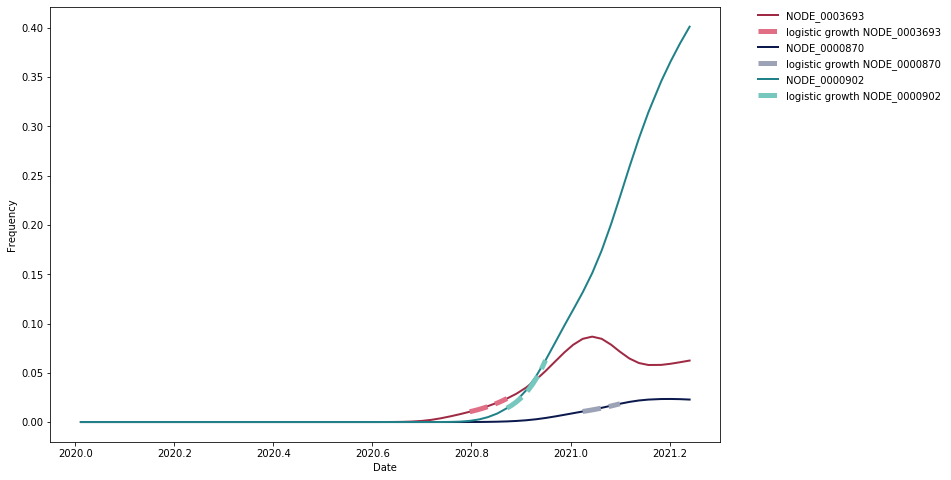

In [48]:
plot_frequency_and_logistic_growth_for_clade(4)

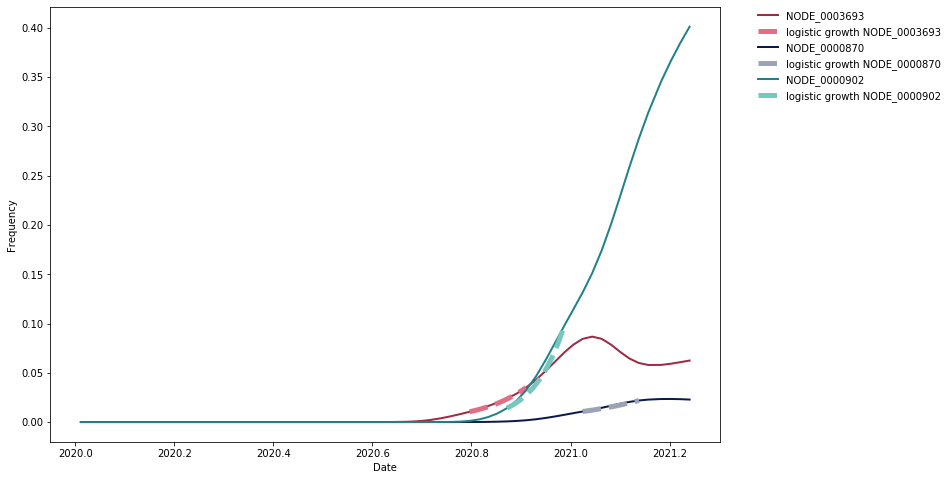

In [47]:
plot_frequency_and_logistic_growth_for_clade(6)